#### Packages

In [119]:
import matplotlib.pyplot as plt
import statsmodels.api as sm
import statsmodels.formula.api as smf
import seaborn as sns
import pandas as pd
import numpy as np
import plotly.express as px
from scipy import stats

#### Load File

In [120]:
diff_file = r'C:/Users/mayda/Downloads/diff.csv'
df = pd.read_csv(diff_file)
df.drop(columns=df.columns[0], axis=1, inplace=True)

stud_data = r'C:/Users/mayda/Downloads/第三波(2005)高中職五專學生問卷資料/CSV/w3_sf_s_cpnp_lv7.0.csv'
df_stud = pd.read_csv(stud_data)
par_data = r"C:/Users/mayda/Downloads/第三波(2005)高中職五專家長問卷資料/w3_sf_p_cpnp_lv7.0.csv"
df_par = pd.read_csv(par_data)

c:\Users\mayda\AppData\Local\Programs\Python\Python39\lib\site-packages\IPython\core\interactiveshell.py:3155: DtypeWarning: Columns (4,5,6) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,
c:\Users\mayda\AppData\Local\Programs\Python\Python39\lib\site-packages\IPython\core\interactiveshell.py:3155: DtypeWarning: Columns (20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,76,77,78,79,80,81,115,148,149,150,151,152,153,154,155,156,157,158,159,160,161,162,163,164,165,166,167,168,169,170,171,172,173,174,175,176,177,178,179,214,215,216,217,218,219,220,221,222,226,228,229,230,231,232,233,234,247,249,251,252,253,254,255,256,257,270,291,292) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,


##### Data Pre-processing

In [121]:
df = df.merge(df_stud[['stud_id', 'w3s303', 'w3s344']], on='stud_id', how='outer')
df = df.merge(df_par[['stud_id', 'w3p103', 'w3p104', 'w3p107', 'w3p108', 'w3p109', 'w3p110', 
                      'w3p312', 'w3p313', 'w3p502', 'w3p505', 'w3p601', 'w3p602']], on='stud_id', how='outer')

df['cp'] = [0 if x >= 30002 else 1 for x in df['stud_id']] # cp=1: 追蹤樣本
df

,stud_id,diff1,diff2,diff3,diff4,diff5,diff6,diff7,diff8,diff9,...,w3p108,w3p109,w3p110,w3p312,w3p313,w3p502,w3p505,w3p601,w3p602,cp
0,2,0.0,1.0,2.0,0.0,1.0,1.0,1.0,1.0,1.0,...,2.0,2.0,2.0,6.0,2.0,3.0,2.0,1.0,3.0,1
1,3,0.0,0.0,2.0,1.0,2.0,1.0,NaN,NaN,0.0,...,3.0,3.0,1.0,2.0,2.0,2.0,2.0,2.0,5.0,1
2,4,0.0,1.0,2.0,1.0,0.0,0.0,3.0,2.0,1.0,...,4.0,4.0,1.0,6.0,2.0,3.0,2.0,1.0,6.0,1
3,10,0.0,NaN,1.0,1.0,0.0,0.0,0.0,0.0,0.0,...,3.0,3.0,2.0,6.0,2.0,2.0,3.0,1.0,4.0,1
4,12,1.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,...,4.0,4.0,1.0,2.0,2.0,2.0,4.0,2.0,4.0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
20131,50128,1.0,1.0,2.0,2.0,1.0,0.0,0.0,1.0,0.0,...,4.0,4.0,1.0,1.0,2.0,1.0,3.0,1.0,3.0,0
20132,50131,1.0,0.0,0.0,2.0,1.0,0.0,1.0,2.0,0.0,...,3.0,3.0,2.0,5.0,2.0,2.0,1.0,2.0,1.0,0
20133,50132,3.0,1.0,1.0,1.0,0.0,0.0,1.0,1.0,1.0,...,3.0,3.0,1.0,5.0,2.0,3.0,2.0,1.0,4.0,0
20134,50134,2.0,0.0,3.0,2.0,1.0,0.0,0.0,1.0,0.0,...,4.0,4.0,1.0,6.0,2.0,2.0,2.0,2.0,5.0,0


In [122]:
# w3p602 您家裡平均每個月的總收入是多少？
df.loc[df['w3p602'] == 1.0, 'w3p602'] = 10000
df.loc[df['w3p602'] == 2.0, 'w3p602'] = 25000
df.loc[df['w3p602'] == 3.0, 'w3p602'] = 40000
df.loc[df['w3p602'] == 4.0, 'w3p602'] = 75000
df.loc[df['w3p602'] == 5.0, 'w3p602'] = 150000
df.loc[df['w3p602'] == 6.0, 'w3p602'] = 250000

In [123]:
m = df.cp==1
old_df=df[m] # 追蹤樣本
new_df=df[~m] # 新樣本

diff_columns = ['diff1', 'diff2', 'diff3', 'diff4', 'diff5', 'diff6', 'diff7', 'diff8', 'diff9', 'diff10', 'diff11', 'diff12']
family_vars = ['w3s303', 'w3s344', 'w3p103', 'w3p104', 'w3p107', 'w3p108', 'w3p109', 'w3p110', 'w3p601', 'w3p602']
all_vars = family_vars + ['diff_avg']

In [124]:
# old_df = old_df.drop(old_df.columns[[13, 14, 15, 16, 17, 18, 19, 20, 21, 22]], axis=1)
old_df['stud_id'] = old_df['stud_id'].astype(str)
old_df['diff_avg'] = old_df[diff_columns].mean(axis=1).round(4)
old_df

<ipython-input-124-645d83225653>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  old_df['stud_id'] = old_df['stud_id'].astype(str)
<ipython-input-124-645d83225653>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  old_df['diff_avg'] = old_df[diff_columns].mean(axis=1).round(4)


,stud_id,diff1,diff2,diff3,diff4,diff5,diff6,diff7,diff8,diff9,...,w3p109,w3p110,w3p312,w3p313,w3p502,w3p505,w3p601,w3p602,cp,diff_avg
0,2,0.0,1.0,2.0,0.0,1.0,1.0,1.0,1.0,1.0,...,2.0,2.0,6.0,2.0,3.0,2.0,1.0,40000.0,1,0.6667
1,3,0.0,0.0,2.0,1.0,2.0,1.0,NaN,NaN,0.0,...,3.0,1.0,2.0,2.0,2.0,2.0,2.0,150000.0,1,0.6000
2,4,0.0,1.0,2.0,1.0,0.0,0.0,3.0,2.0,1.0,...,4.0,1.0,6.0,2.0,3.0,2.0,1.0,250000.0,1,0.8333
3,10,0.0,NaN,1.0,1.0,0.0,0.0,0.0,0.0,0.0,...,3.0,2.0,6.0,2.0,2.0,3.0,1.0,75000.0,1,0.1818
4,12,1.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,...,4.0,1.0,2.0,2.0,2.0,4.0,2.0,75000.0,1,0.3333
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4256,20031,1.0,1.0,2.0,0.0,0.0,0.0,1.0,NaN,0.0,...,3.0,1.0,6.0,2.0,1.0,1.0,2.0,75000.0,1,0.4545
4257,20033,0.0,0.0,1.0,0.0,1.0,0.0,2.0,1.0,0.0,...,2.0,1.0,6.0,2.0,2.0,4.0,2.0,40000.0,1,0.4167
4258,20040,1.0,0.0,1.0,0.0,0.0,0.0,3.0,2.0,1.0,...,4.0,1.0,6.0,4.0,2.0,2.0,1.0,75000.0,1,0.6667
4259,20045,0.0,1.0,1.0,2.0,2.0,1.0,1.0,2.0,0.0,...,3.0,1.0,6.0,1.0,6.0,99.0,4.0,10000.0,1,0.8333


#### 主動的家長

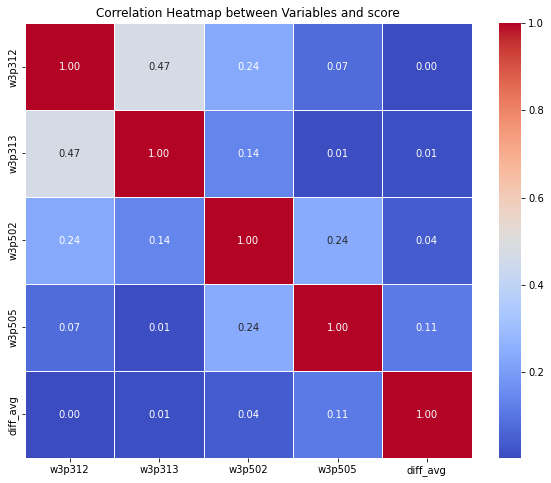

In [133]:
act_vars = ['w3p312', 'w3p313', 'w3p502', 'w3p505']
total_vars = act_vars + ['diff_avg']

correlation_matrix = old_df[total_vars].corr()

# Plotting the heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f", linewidths=0.5)
plt.title('Correlation Heatmap between Variables and score')
plt.show()

#### 依照分數分群

In [125]:
old_df['diff_avg'].describe()

count    4170.000000
mean        0.771217
std         0.412712
min         0.000000
25%         0.500000
50%         0.666700
75%         0.916700
max         4.000000
Name: diff_avg, dtype: float64

In [126]:
quantile_20 = old_df['diff_avg'].quantile(0.20)
quantile_80 = old_df['diff_avg'].quantile(0.80)

# Create the 'knowwell' and 'knowpoor' columns
old_df['knowwell'] = (old_df['diff_avg'] <= quantile_20).astype(int)
old_df['knowpoor'] = (old_df['diff_avg'] >= quantile_80).astype(int)

<ipython-input-126-0e49e63388a3>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  old_df['knowwell'] = (old_df['diff_avg'] <= quantile_20).astype(int)
<ipython-input-126-0e49e63388a3>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  old_df['knowpoor'] = (old_df['diff_avg'] >= quantile_80).astype(int)


##### 很了解子女

In [127]:
w = old_df.knowwell==1
df_well = old_df[w]

In [128]:
stat_summary = df_well[all_vars].describe()
print(stat_summary)

           w3s303      w3s344      w3p103      w3p104      w3p107      w3p108  \
count  879.000000  879.000000  879.000000  879.000000  879.000000  879.000000   
mean     4.412969    4.230944    1.224118    2.646189    1.502844    3.003413   
std      6.560312   14.480767    0.673995    1.354552    0.671366    0.890976   
min      1.000000    1.000000    1.000000    1.000000    1.000000    1.000000   
25%      3.000000    1.000000    1.000000    1.000000    1.000000    2.000000   
50%      5.000000    2.000000    1.000000    3.000000    1.000000    3.000000   
75%      5.000000    2.000000    1.000000    3.000000    2.000000    4.000000   
max     99.000000   99.000000    5.000000    6.000000    4.000000    4.000000   

           w3p109      w3p110      w3p601         w3p602    diff_avg  
count  879.000000  879.000000  879.000000     879.000000  879.000000  
mean     3.282139    1.149033    2.108077   62850.279863    0.341294  
std      0.802920    0.356324    4.710132   45711.116758 

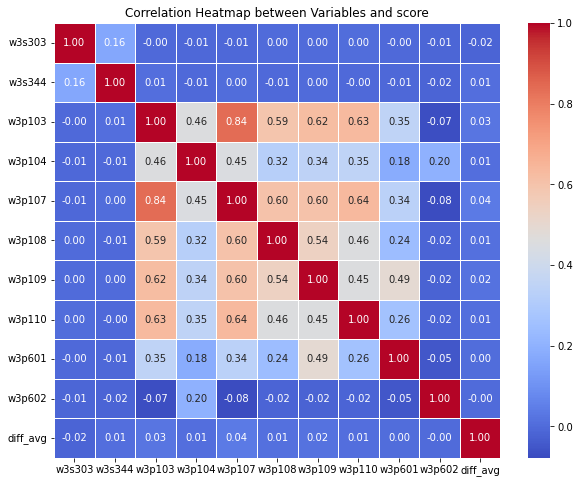

In [132]:
correlation_matrix = old_df[all_vars].corr()

# Plotting the heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f", linewidths=0.5)
plt.title('Correlation Heatmap between Variables and score')
plt.show()

In [130]:
# Define the dependent variable
dependent_var = 'diff_avg'

# Create the formula for the regression model
formula = f"{dependent_var} ~ " + " + ".join(family_vars)

# Fit the regression model
model = smf.ols(formula=formula, data=old_df).fit()

# Print the summary of the regression analysis
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:               diff_avg   R-squared:                       0.003
Model:                            OLS   Adj. R-squared:                  0.000
Method:                 Least Squares   F-statistic:                     1.158
Date:                Sun, 19 May 2024   Prob (F-statistic):              0.314
Time:                        09:41:47   Log-Likelihood:                -2220.2
No. Observations:                4170   AIC:                             4462.
Df Residuals:                    4159   BIC:                             4532.
Df Model:                          10                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      0.7616      0.016     46.972      0.0